In [1]:
# extra analysis for supplmental figure and fig 4 and 5

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import linregress
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import ShuffleSplit, LeaveOneOut
from brainspace.gradient import GradientMaps

### Setting path

In [3]:
# Set this to your git-repo path for running the analyses.
main_path = "/srv/khan/users/sudesnac/00_Projects/HumanBF-Connectivity"

In [4]:
# Setting other paths
data_path = main_path + "/data/"
results_path = main_path + "/results/extra_analysis/"
fig_path = main_path + "/results/extra_analysis/figures/"

In [5]:
Func_results = main_path + "/results/Func_gradients/"
Diff_results = main_path + "/results/Diff_gradients/"
Gradc_results = main_path + "/results/gradient_correlation/"
Conn_results = main_path + "/results/connectivity_distance/"

### Supplemental Figure 4

In [8]:
# Load residuals
resid_results = pd.read_csv(Gradc_results + 'Struct_vs_Func_linear_least-squares_regression_s6-f4_residuals_statsmodels.csv')

In [9]:
# Squared 
resid_squared = resid_results**2

In [10]:
# Extract unweighted average and sg1-fg1 residuals
unweighted_avg_resid_squared = np.nanmean(resid_squared.values, axis=1)
sg1_fg1_resid_squared        = resid_squared[resid_squared.columns[0]].values

In [11]:
# Pearson's correlation
corr = linregress(sg1_fg1_resid_squared, unweighted_avg_resid_squared)
print(corr)

LinregressResult(slope=0.1993599689267975, intercept=0.0031768639201613046, rvalue=0.918104164701181, pvalue=3.951341853013897e-242, stderr=0.0035222958969123455, intercept_stderr=9.842016869870291e-05)


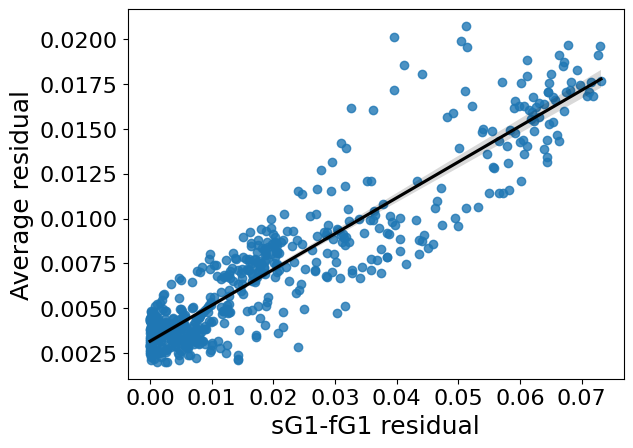

In [12]:
# Plot correlation
sc = sns.regplot(
    x=sg1_fg1_resid_squared,
    y=unweighted_avg_resid_squared,
    line_kws={'color': 'black'},
)
#sc.axes.set_ylim(0,0.01,0.04)
#sc.axes.set_xlim(0, 0.08)

sc.set_xlabel('sG1-fG1 residual',fontsize=18)
sc.set_ylabel('Average residual',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig(fig_path + f'Unweighted-average_vs_sg1-fg1_residuals-corr.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

#### sG1-fG1 vs average (except sG1-fG1)

In [13]:
resid_squared_except_sg1fg1 = resid_squared.drop('(0, 0)', axis=1)

In [14]:
#resid_squared_except_sg1fg1 

In [15]:
# Extract unweighted average and sg1-fg1 residuals
avg_exceptg1s_resid_squared = np.nanmean(resid_squared_except_sg1fg1.values, axis=1)
sg1_fg1_resid_squared        = resid_squared[resid_squared.columns[0]].values

In [16]:
# Pearson's correlation
corr = linregress(sg1_fg1_resid_squared, avg_exceptg1s_resid_squared)
print(corr)

LinregressResult(slope=0.16454953279318005, intercept=0.003314988438429186, rvalue=0.8777837379082906, pvalue=5.772675409535993e-193, stderr=0.0036754391967780946, intercept_stderr=0.0001026993064682116)


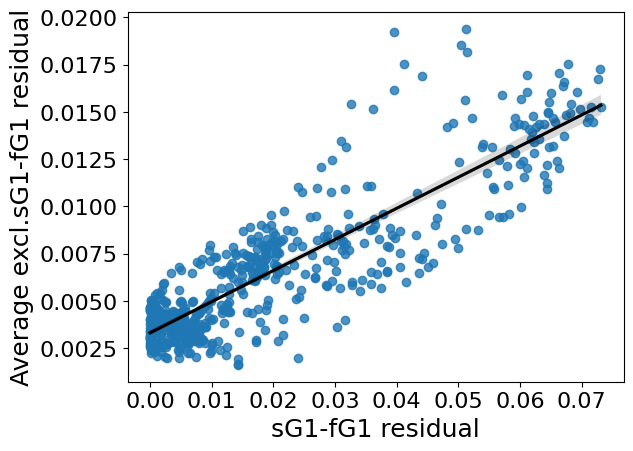

In [17]:
# Plot correlation
sc = sns.regplot(
    x=sg1_fg1_resid_squared,
    y=avg_exceptg1s_resid_squared,
    line_kws={'color': 'black'}
)
#sc.axes.set_ylim(0, 0.04)
#sc.axes.set_xlim(0, 0.08)

sc.set_xlabel('sG1-fG1 residual',fontsize=18)
sc.set_ylabel('Average excl.sG1-fG1 residual',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig(fig_path + f'Unweighted-average-excluding-G1s_vs_sg1-fg1_residuals-corr.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

### Supplemental Figure 3 (two groups)

#### Structural

In [18]:
# Load data
# data_path = '/project/6050199/sudesnac/21_Codes/HumanBF-Parcellation/data'
dmri_data = np.load(data_path + 'tpl-MNI152NLin6Asym_label-fullBF_desc-concat_from-7Tgroup_connMap.npz')

In [19]:
# Correlation matrix
dmri_correlation = dmri_data['conn_group']
dmri_avg_correlation = np.nanmean(dmri_correlation, axis=0)
dmri_avg_correlation += 1

In [20]:
# Define split between 'train' and 'test'
n_splits = 1000 # should be something like 1000-5000
rs       = ShuffleSplit(n_splits=n_splits, test_size=.5, random_state=0)
X        = np.zeros((dmri_correlation.shape[0],1))

In [21]:
dmri_g_train_vals = []
dmri_g_test_vals  = []
dmri_corr_vals    = []

for i, (train_index, test_index) in enumerate(rs.split(X)):    
    # Train dataset average
    dmri_train_avg_correlation = np.nanmean(dmri_correlation[train_index,:,:], axis=0)
    
    # Train dataset average
    dmri_test_avg_correlation = np.nanmean(dmri_correlation[test_index,:,:], axis=0)
    
    # Compute principal gradient, with Procrustus alignment to average across all subjects
    dmri_gp_train = GradientMaps(
        n_components=1, 
        kernel='normalized_angle',
        approach='dm',
        alignment='procrustes',
        random_state=0
    )
    dmri_gp_train.fit([dmri_avg_correlation, dmri_train_avg_correlation])
    dmri_g_train_vals.append(dmri_gp_train.aligned_[1][:,0])
    
    # Now for test dataset
    dmri_gp_test = GradientMaps(
        n_components=1, 
        kernel='normalized_angle',
        approach='dm',
        alignment='procrustes',
        random_state=0
    )
    dmri_gp_test.fit([dmri_avg_correlation, dmri_test_avg_correlation])
    dmri_g_test_vals.append(dmri_gp_test.aligned_[1][:,0])
    
    # Pearson's correlation
    # Change to Spearman
    corr = linregress(dmri_gp_train.aligned_[1][:,0], dmri_gp_test.aligned_[1][:,0])
    dmri_corr_vals.append(corr.rvalue)

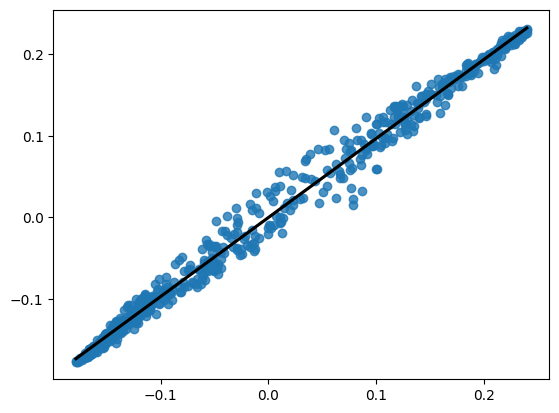

In [22]:
# Plot correlation
sc = sns.regplot(
    x=dmri_gp_train.aligned_[1],
    y=dmri_gp_test.aligned_[1],
    line_kws={'color': 'black'}
)
plt.savefig(fig_path + f'dMRI_split-half_scatter-plot.png', dpi=300, bbox_inches='tight')
plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


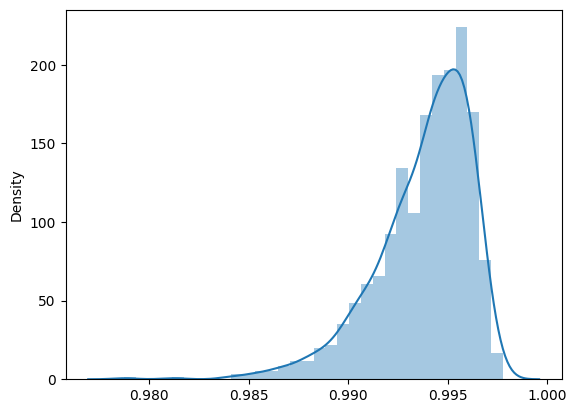

In [23]:
sns.distplot(dmri_corr_vals)
plt.savefig(fig_path + f'dMRI_split-half_dist-plot.png', dpi=300, bbox_inches='tight')
plt.show()

#### Functional

In [24]:
# Load data
#data_path = '/project/6050199/sudesnac/21_Codes/HumanBF-Parcellation/data'
fmri_data = np.load(data_path + 'correlation_matrix_HCP-MMP_group.npz')

In [25]:
# Correlation matrix
fmri_correlation     = fmri_data['corr_group']
indices              = fmri_data['indices']
fmri_avg_correlation = np.nanmean(fmri_correlation, axis=0)
fmri_avg_correlation += 1

In [26]:
fmri_g_train_vals = []
fmri_g_test_vals  = []
fmri_corr_vals    = []

# Use same splits as for the structural data
for i, (train_index, test_index) in enumerate(rs.split(X)):    
    # Train dataset average
    fmri_train_avg_correlation = np.nanmean(fmri_correlation[train_index,:,:], axis=0)
    
    # Train dataset average
    fmri_test_avg_correlation = np.nanmean(fmri_correlation[test_index,:,:], axis=0)
    
    # Compute principal gradient, with Procrustus alignment to average across all subjects
    fmri_gp_train = GradientMaps(
        n_components=1, 
        kernel='normalized_angle',
        approach='dm',
        alignment='procrustes',
        random_state=0
    )
    fmri_gp_train.fit([fmri_avg_correlation, fmri_train_avg_correlation])
    fmri_g_train_vals.append(fmri_gp_train.aligned_[1][:,0])
    
    # Now for test dataset
    fmri_gp_test = GradientMaps(
        n_components=1, 
        kernel='normalized_angle',
        approach='dm',
        alignment='procrustes',
        random_state=0
    )
    fmri_gp_test.fit([fmri_avg_correlation, fmri_test_avg_correlation])
    fmri_g_test_vals.append(fmri_gp_test.aligned_[1][:,0])
    
    # Pearson's correlation
    corr = linregress(fmri_gp_train.aligned_[1][:,0], fmri_gp_test.aligned_[1][:,0])
    fmri_corr_vals.append(corr.rvalue)

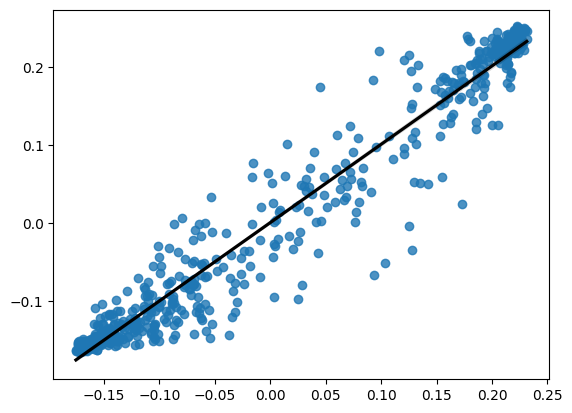

In [27]:
# Plot correlation
sc = sns.regplot(
    x=fmri_gp_train.aligned_[1],
    y=fmri_gp_test.aligned_[1],
    line_kws={'color': 'black'}
)
plt.savefig(fig_path + f'rsfMRI_split-half_scatter-plot.png', dpi=300, bbox_inches='tight')
plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


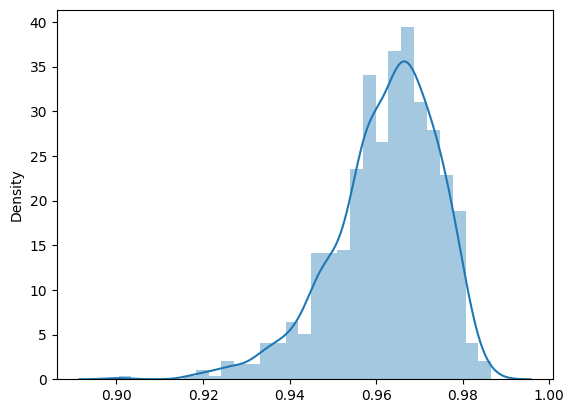

In [28]:
sns.distplot(fmri_corr_vals)
plt.savefig(fig_path + f'rsfMRI_split-half_dist-plot.png', dpi=300, bbox_inches='tight')
plt.show()

#### Residuals

In [29]:
resid_train_vals = []
resid_test_vals  = []
resid_corr_vals  = []

# Calculate residuals
for i in range(n_splits):    

    # Train
    model = sm.OLS(
        dmri_g_train_vals[i],
        fmri_g_train_vals[i]
    )
    train_results = model.fit()
    resid_train_vals.append(train_results.resid)

    # Test
    model = sm.OLS(
        dmri_g_test_vals[i],
        fmri_g_test_vals[i]
    )
    test_results = model.fit()    
    resid_test_vals.append(test_results.resid)

    # Pearson's correlation
    corr = linregress(train_results.resid, test_results.resid)
    resid_corr_vals.append(corr.rvalue)

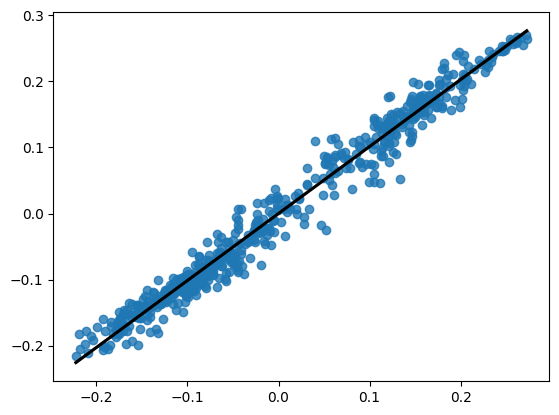

In [30]:
# Plot correlation
sc = sns.regplot(
    x=resid_train_vals[0],
    y=resid_test_vals[0],
    line_kws={'color': 'black'}
)
plt.savefig(fig_path + f'Residuals_split-half_scatter-plot.png', dpi=300, bbox_inches='tight')
plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


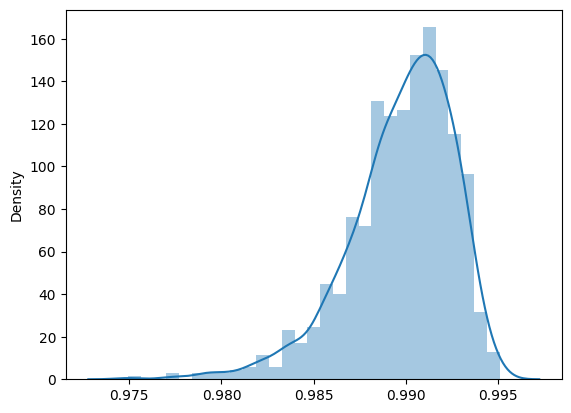

In [31]:
sns.distplot(resid_corr_vals)
plt.savefig(fig_path + f'Residuals_split-half_dist-plot.png', dpi=300, bbox_inches='tight')
plt.show()

### Supplemental Figure 3 (leave one out)

#### Structural

In [32]:
# Define splits
loo      = LeaveOneOut()
X        = np.zeros((dmri_correlation.shape[0],1))
n_splits = loo.get_n_splits(X)

In [33]:
dmri_g_train_loo_vals = []
dmri_g_test_loo_vals  = []
dmri_corr_loo_vals    = []

for i, (train_index, test_index) in enumerate(loo.split(X)):    
    # Train dataset average
    dmri_train_avg_correlation = np.nanmean(dmri_correlation[train_index,:,:], axis=0)
    
    # Train dataset average
    dmri_test_avg_correlation = np.nanmean(dmri_correlation[test_index,:,:], axis=0)
    
    # Compute principal gradient, with Procrustus alignment to average across all subjects
    dmri_gp_train = GradientMaps(
        n_components=1, 
        kernel='normalized_angle',
        approach='dm',
        alignment='procrustes',
        random_state=0
    )
    dmri_gp_train.fit([dmri_avg_correlation, dmri_train_avg_correlation])
    dmri_g_train_loo_vals.append(dmri_gp_train.aligned_[1][:,0])
    
    # Now for test dataset
    dmri_gp_test = GradientMaps(
        n_components=1, 
        kernel='normalized_angle',
        approach='dm',
        alignment='procrustes',
        random_state=0
    )
    dmri_gp_test.fit([dmri_avg_correlation, dmri_test_avg_correlation])
    dmri_g_test_loo_vals.append(dmri_gp_test.aligned_[1][:,0])
    
    # Pearson's correlation
    # Change to Spearman
    corr = linregress(dmri_gp_train.aligned_[1][:,0], dmri_gp_test.aligned_[1][:,0])
    dmri_corr_loo_vals.append(corr.rvalue)

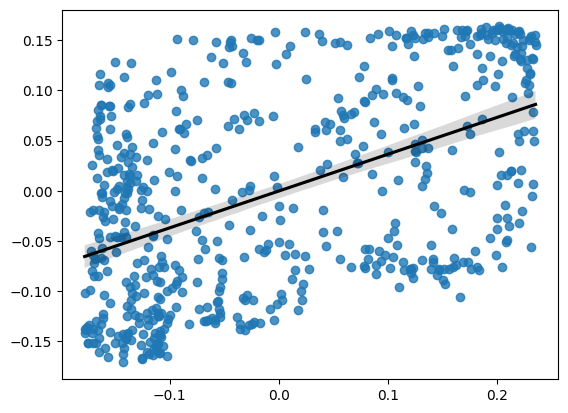

In [34]:
# Plot correlation
sc = sns.regplot(
    x=dmri_gp_train.aligned_[1],
    y=dmri_gp_test.aligned_[1],
    line_kws={'color': 'black'}
)
plt.savefig(fig_path + f'dMRI_leave-one-out_scatter-plot.png', dpi=300, bbox_inches='tight')
plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


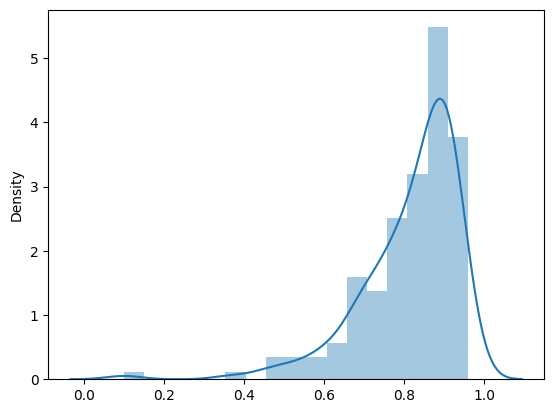

In [35]:
sns.distplot(dmri_corr_loo_vals)
plt.savefig(fig_path + f'dMRI_leave-one-out_dist-plot.png', dpi=300, bbox_inches='tight')
plt.show()

#### Functional

In [36]:
fmri_g_train_loo_vals = []
fmri_g_test_loo_vals  = []
fmri_corr_loo_vals    = []

# Use same splits as for the structural data
for i, (train_index, test_index) in enumerate(loo.split(X)):    
    # Train dataset average
    fmri_train_avg_correlation = np.nanmean(fmri_correlation[train_index,:,:], axis=0)
    
    # Train dataset average
    fmri_test_avg_correlation = np.nanmean(fmri_correlation[test_index,:,:], axis=0)
    
    # Compute principal gradient, with Procrustus alignment to average across all subjects
    fmri_gp_train = GradientMaps(
        n_components=1, 
        kernel='normalized_angle',
        approach='dm',
        alignment='procrustes',
        random_state=0
    )
    fmri_gp_train.fit([fmri_avg_correlation, fmri_train_avg_correlation])
    fmri_g_train_loo_vals.append(fmri_gp_train.aligned_[1][:,0])
    
    # Now for test dataset
    fmri_gp_test = GradientMaps(
        n_components=1, 
        kernel='normalized_angle',
        approach='dm',
        alignment='procrustes',
        random_state=0
    )
    fmri_gp_test.fit([fmri_avg_correlation, fmri_test_avg_correlation])
    fmri_g_test_loo_vals.append(fmri_gp_test.aligned_[1][:,0])
    
    # Pearson's correlation
    corr = linregress(fmri_gp_train.aligned_[1][:,0], fmri_gp_test.aligned_[1][:,0])
    fmri_corr_loo_vals.append(corr.rvalue)

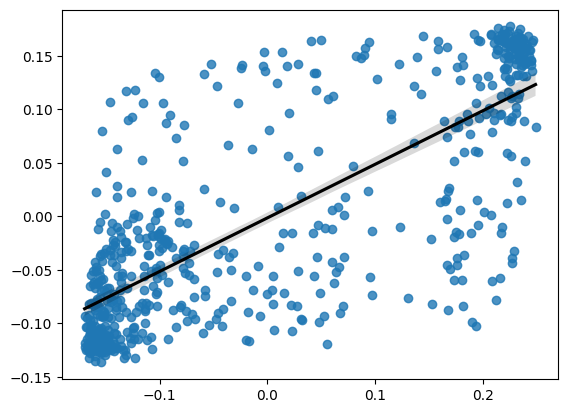

In [37]:
# Plot correlation
sc = sns.regplot(
    x=fmri_gp_train.aligned_[1],
    y=fmri_gp_test.aligned_[1],
    line_kws={'color': 'black'}
)
plt.savefig(fig_path + f'rsfMRI_leave-one-out_scatter-plot.png', dpi=300, bbox_inches='tight')
plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


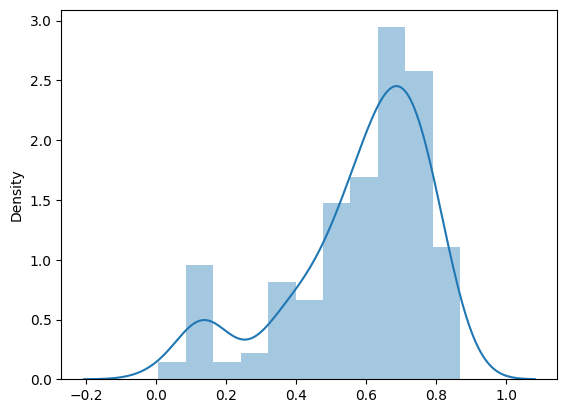

In [38]:
sns.distplot(fmri_corr_loo_vals)
plt.savefig(fig_path + f'rsfMRI_leave-one-out_dist-plot.png', dpi=300, bbox_inches='tight')
plt.show()

#### Residuals

In [39]:
resid_train_loo_vals = []
resid_test_loo_vals  = []
resid_corr_loo_vals  = []

# Calculate residuals
for i in range(n_splits):    

    # Train
    model = sm.OLS(
        dmri_g_train_loo_vals[i],
        fmri_g_train_loo_vals[i]
    )
    train_results = model.fit()
    resid_train_loo_vals.append(train_results.resid)

    # Test
    model = sm.OLS(
        dmri_g_test_loo_vals[i],
        fmri_g_test_loo_vals[i]
    )
    test_results = model.fit()    
    resid_test_loo_vals.append(test_results.resid)

    # Pearson's correlation
    corr = linregress(train_results.resid, test_results.resid)
    resid_corr_loo_vals.append(corr.rvalue)

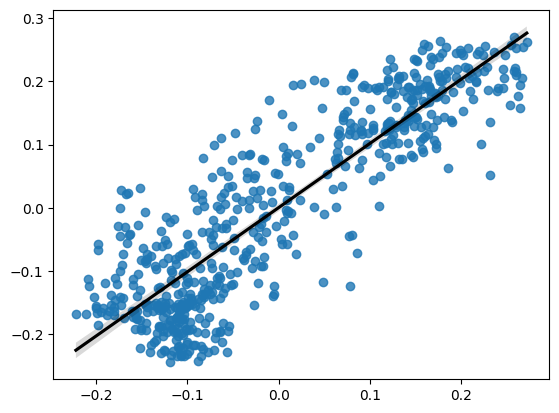

In [40]:
# Plot correlation
sc = sns.regplot(
    x=resid_train_loo_vals[0],
    y=resid_test_loo_vals[0],
    line_kws={'color': 'black'}
)
plt.savefig(fig_path + f'Residuals_leave-one-out_scatter-plot.png', dpi=300, bbox_inches='tight')
plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


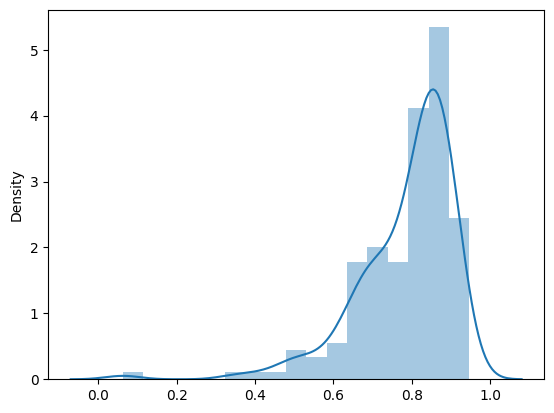

In [41]:
sns.distplot(resid_corr_loo_vals)
plt.savefig(fig_path + f'Residuals_leave-one-out_dist-plot.png', dpi=300, bbox_inches='tight')
plt.show()

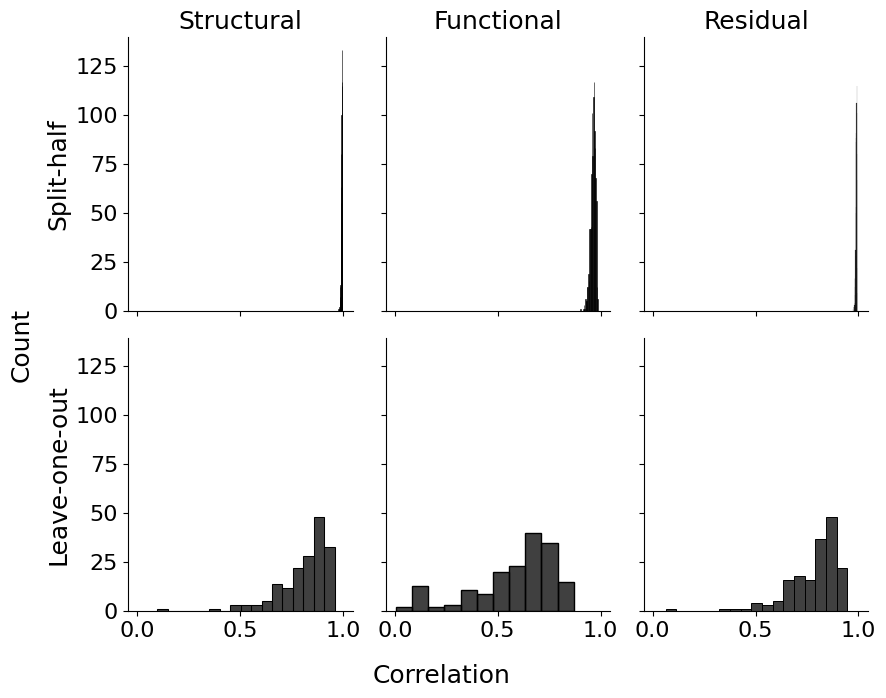

In [44]:
import matplotlib

matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 


fig, ax = plt.subplots(2,3, sharex=True, sharey=True, figsize=(9,7))

# Split
g1=sns.histplot(dmri_corr_vals, stat='count', color='black', ax=ax[0,0])
sns.histplot(fmri_corr_vals, stat='count', color='black', ax=ax[0,1])
sns.histplot(resid_corr_vals, stat='count', color='black', ax=ax[0,2])
g1.set_ylabel('Split-half', fontsize=18)

# Leave one out
g2=sns.histplot(dmri_corr_loo_vals, stat='count', color='black', ax=ax[1,0])
sns.histplot(fmri_corr_loo_vals, stat='count', color='black', ax=ax[1,1])
sns.histplot(resid_corr_loo_vals, stat='count', color='black', ax=ax[1,2])
g2.set_ylabel('Leave-one-out', fontsize=18)

sns.despine()

ax[0, 0].set_title("Structural",fontsize=18)
ax[0, 1].set_title("Functional",fontsize=18)
ax[0, 2].set_title("Residual",fontsize=18)

fig.supxlabel("Correlation", fontsize=18)
fig.supylabel("Count", fontsize=18)

plt.tight_layout()
plt.savefig(fig_path + f'rsfMRI-dMRI-resid_split_leave-one-out_dist-plot.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()